In [1]:
import os, sys
from pathlib import Path

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

In [3]:
model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
## quantization

In [5]:
import torch
from transformers import BitsAndBytesConfig

quantization_config_4bit = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_use_double_quant=True)

model_id = 'microsoft/Florence-2-base'
model_4bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config_4bit,
    trust_remote_code=True
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [6]:
print(f"The model size is {model.get_memory_footprint() * 1e-9} GB")
print(f"The model_4bit size is {model_4bit.get_memory_footprint() * 1e-9} GB")

The model size is 1.083830628 GB
The model_4bit size is 0.267647154 GB


In [7]:
## plot

In [8]:
def run_example(model, image, task_prompt, text_input=None, quantized = False):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    if quantized:
        inputs = inputs.to(dtype=torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

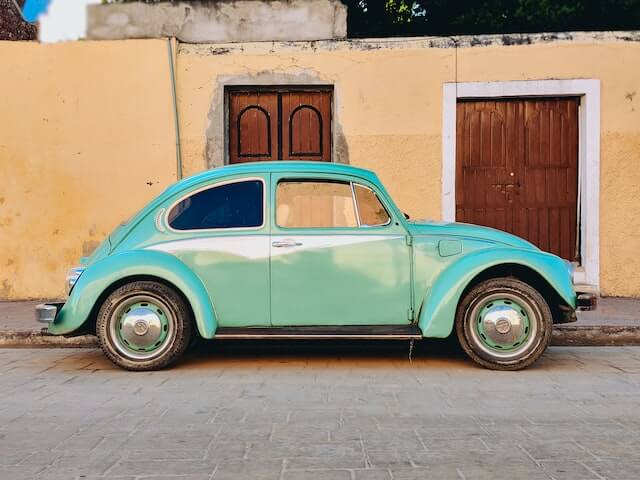

In [3]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [6]:
image.size

(640, 480)

In [11]:
task_prompt = '<CAPTION>'
print(run_example(model_4bit, image, task_prompt, quantized=True))

{'<CAPTION>': 'A green car parked in front of a yellow building.'}


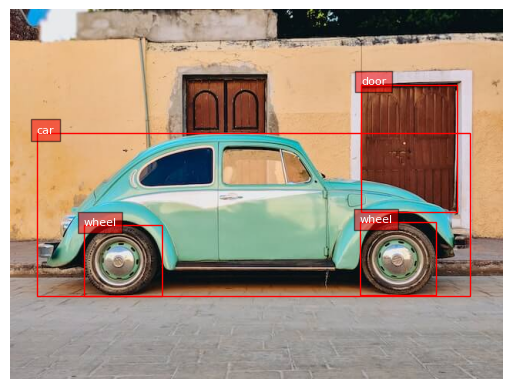

In [12]:
task_prompt = '<OD>'

result_model_4bit = run_example(model_4bit, image, task_prompt, quantized=True)
plot_bbox(image, result_model_4bit['<OD>'])

In [5]:
doc_img = Image.open("../data/converted/0000000869.jpg").convert("RGB")

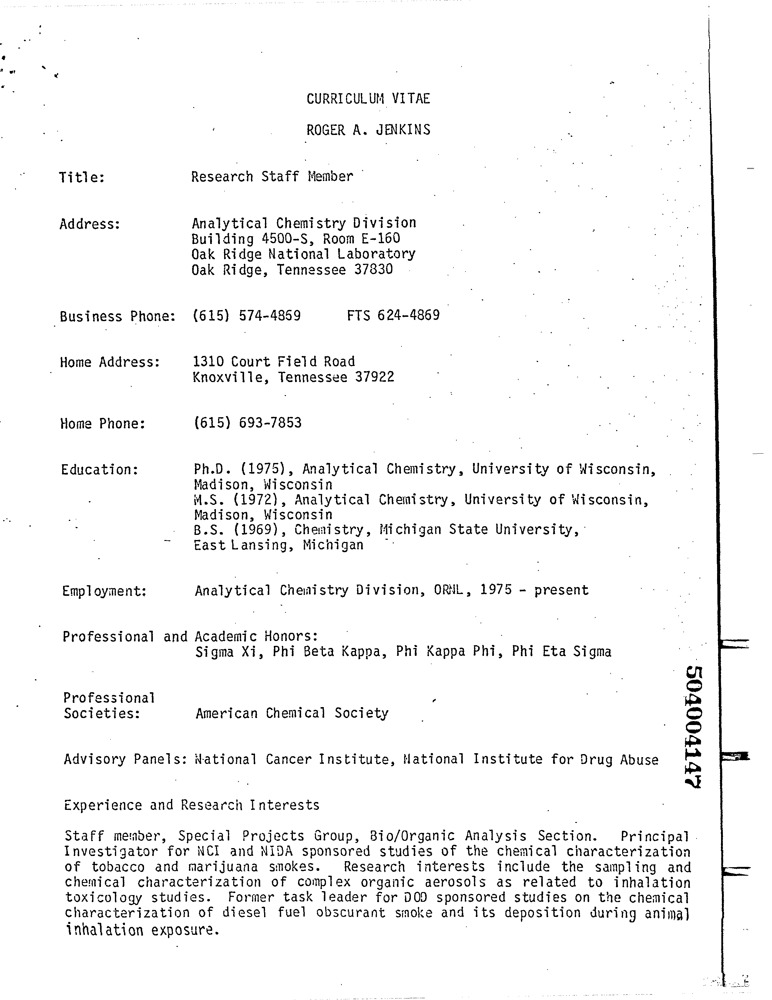

In [6]:
doc_img

In [27]:
task_prompt = '<OCR>'

result_model_4bit = run_example(model_4bit, doc_img, task_prompt, quantized=True)
print(result_model_4bit['<OCR>'])

CURRICULUM VITAEROGER A. JENKINSTitle:Research Staff MemberAddress:Analytical Chemistry DivisionBuilding 4500-S, Room E-160Oak Ridge National LaboratoryOak Ridge, Tennessee 37830Business Phone: (615) 574-4869FTS 624-4889Home Address:1310 Court Field RoadKnoxville, Tennessee 37922Home Phone:(615) 693-8753Education:Ph.D. (1975) Analytical Chemistry, University of Wisconsin,M.S. (1972) (Chemistry, Michigan State University,East Lansing, MichiganEmployment:Analytic Chemistry Division, Orill, 1975 - presentProfessional and Academic Honors:Sigma Xi, Phi Beta Kappa, Phi Kappa Phi, Phi Eta SigmaSocieties:American Chemical SocietyAFFYFOODFOOSExperience and Research InterestsStaff member: Special Projects Group, Bio/Organic Analysis Section, Principalof tobacco and NCL and NIDA Spanned Studies of the chemical characterization andResearch interests include the sampling andchemical Characterization of former task leader for DOD sponsored studies on the chemicalcharacterization of diesel fuel obser

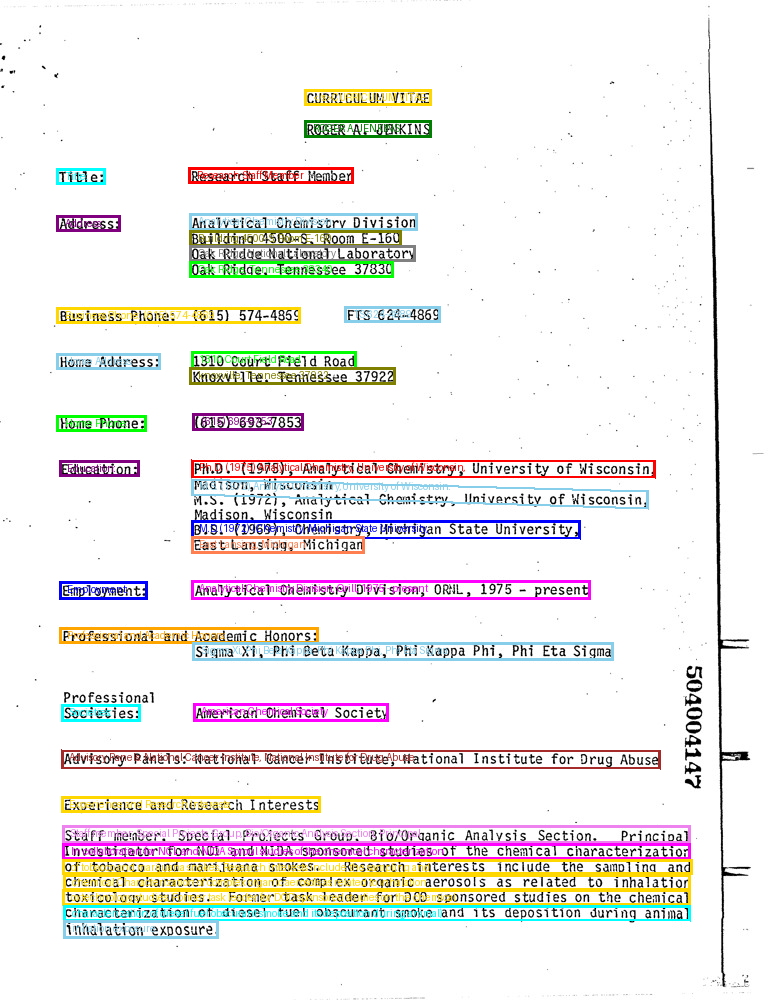

In [28]:
task_prompt = '<OCR_WITH_REGION>'
result_model_4bit = run_example(model_4bit, doc_img, task_prompt, quantized=True)
output_image = copy.deepcopy(doc_img)
draw_ocr_bboxes(output_image, result_model_4bit['<OCR_WITH_REGION>'])

In [29]:
## Mini cpm

In [1]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer
from transformers import BitsAndBytesConfig

/home/ajkdrag/workspace/projects/object-detection-impl/.venv/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Whether to perform 4-bit quantization
    load_in_8bit=False,  # Whether to perform 8-bit quantization
    bnb_4bit_compute_dtype=torch.float16,  # Computation precision setting
    bnb_4bit_quant_storage=torch.uint8,  # Storage format for quantized weights
    bnb_4bit_quant_type="nf4",  # Quantization format, here using normally distributed int4
    bnb_4bit_use_double_quant=True,  # Whether to use double quantization, i.e., quantizing zeropoint and scaling parameters
    llm_int8_enable_fp32_cpu_offload=False,  # Whether LLM uses int8, with fp32 parameters stored on the CPU
    llm_int8_has_fp16_weight=False,  # Whether mixed precision is enabled
    llm_int8_skip_modules=["out_proj", "kv_proj", "lm_head"],  # Modules not to be quantized
    llm_int8_threshold=6.0  # Outlier value in the llm.int8() algorithm, distinguishing whether to perform quantization based on this value
)

In [5]:
model_id = 'openbmb/MiniCPM-V'
model = AutoModel.from_pretrained(model_id, trust_remote_code=True, device_map="cuda",
                                             attn_implementation='sdpa', quantization_config=quantization_config)
# processor = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

/home/ajkdrag/workspace/projects/object-detection-impl/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ajkdrag/workspace/projects/object-detection-impl/.venv/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ajkdrag/workspace/projects/object-detection-impl/.venv/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ajkdrag/workspace/projects/object-detection-impl/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
processor = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [8]:
print(f"The model_4bit size is {model.get_memory_footprint() * 1e-9} GB")

The model_4bit size is 2.697247296 GB


In [9]:
doc_image = Image.open("../data/converted/0000000869.jpg").convert("RGB")

In [16]:
response = model.chat(
    image=doc_image,
    msgs=[
        {
            "role": "user",
            "content": "What is the `Home Phone` field this picture?"
        }
    ],
    tokenizer=processor,
    context=None,
)

In [17]:
print(response[0])

(615) 322-4898


In [18]:
## deepseek vlm

In [19]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

In [20]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [30]:
model_path = "deepseek-ai/deepseek-vl-1.3b-chat"

In [31]:
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)

KeyError: 'multi_modality'

In [29]:
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path, 
                                              trust_remote_code=True, low_cpu_mem_usage=True)#, 
#                                              quantization_config=quantization_config, device_map="cuda")


KeyError: 'multi_modality'

In [ ]:

from deepseek_vl.models import VLChatProcessor, MultiModalityCausalLM
from deepseek_vl.utils.io import load_pil_images

#if you're on a 3XXX or 4XXX card, i think you can change the torch.float16 to torch.bfloat16
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)


# specify the path to the model
model_path = "DeepSeek-VL/deepseek-vl-7b-chat" #or "c:/local/path/to/deepseek-vl-7b-chat"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True, low_cpu_mem_usage=True, quantization_config=quantization_config, device_map="cuda")

conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>Describe each stage of this image.",
        "images": ["./PATH/TO/YOUR/IMAGE/HERE.png"]
    },
    {
        "role": "Assistant",
        "content": ""
    }
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(answer)